![](https://i.imgur.com/eBRPvWB.png)

# Practical PyTorch: Translation with a Sequence to Sequence Network and Attention

In this project we will be teaching a neural network to translate from French to English.

```
[KEY: > input, = target, < output]

> il est en train de peindre un tableau .
= he is painting a picture .
< he is painting a picture .

> pourquoi ne pas essayer ce vin delicieux ?
= why not try that delicious wine ?
< why not try that delicious wine ?

> elle n est pas poete mais romanciere .
= she is not a poet but a novelist .
< she not not a poet but a novelist .

> vous etes trop maigre .
= you re too skinny .
< you re all alone .
```

... to varying degrees of success.

This is made possible by the simple but powerful idea of the [sequence to sequence network](http://arxiv.org/abs/1409.3215), in which two recurrent neural networks work together to transform one sequence to another. An encoder network condenses an input sequence into a single vector, and a decoder network unfolds that vector into a new sequence.

To improve upon this model we'll use an [attention mechanism](https://arxiv.org/abs/1409.0473), which lets the decoder learn to focus over a specific range of the input sequence.

# The Sequence to Sequence model

A [Sequence to Sequence network](http://arxiv.org/abs/1409.3215), or seq2seq network, or [Encoder Decoder network](https://arxiv.org/pdf/1406.1078v3.pdf), is a model consisting of two separate RNNs called the **encoder** and **decoder**. The encoder reads an input sequence one item at a time, and outputs a vector at each step. The final output of the encoder is kept as the **context** vector. The decoder uses this context vector to produce a sequence of outputs one step at a time.

![](https://i.imgur.com/tVtHhNp.png)

When using a single RNN, there is a one-to-one relationship between inputs and outputs. We would quickly run into problems with different sequence orders and lengths that are common during translation. Consider the simple sentence "Je ne suis pas le chat noir" &rarr; "I am not the black cat". Many of the words have a pretty direct translation, like "chat" &rarr; "cat". However the differing grammars cause words to be in different orders, e.g. "chat noir" and "black cat". There is also the "ne ... pas" &rarr; "not" construction that makes the two sentences have different lengths.

With the seq2seq model, by encoding many inputs into one vector, and decoding from one vector into many outputs, we are freed from the constraints of sequence order and length. The encoded sequence is represented by a single vector, a single point in some N dimensional space of sequences. In an ideal case, this point can be considered the "meaning" of the sequence.

This idea can be extended beyond sequences. Image captioning tasks take an [image as input, and output a description](https://arxiv.org/abs/1411.4555) of the image (img2seq). Some image generation tasks take a [description as input and output a generated image](https://arxiv.org/abs/1511.02793) (seq2img). These models can be referred to more generally as "encoder decoder" networks.

## The Attention Mechanism

The fixed-length vector carries the burden of encoding the the entire "meaning" of the input sequence, no matter how long that may be. With all the variance in language, this is a very hard problem. Imagine two nearly identical sentences, twenty words long, with only one word different. Both the encoders and decoders must be nuanced enough to represent that change as a very slightly different point in space.

The **attention mechanism** [introduced by Bahdanau et al.](https://arxiv.org/abs/1409.0473) addresses this by giving the decoder a way to "pay attention" to parts of the input, rather than relying on a single vector. For every step the decoder can select a different part of the input sentence to consider.

![](https://i.imgur.com/5y6SCvU.png)

Attention is calculated with another feedforward layer in the decoder. This layer will use the current input and hidden state to create a new vector, which is the same size as the input sequence (in practice, a fixed maximum length). This vector is processed through softmax to create *attention weights*, which are multiplied by the encoders' outputs to create a new context vector, which is then used to predict the next output.

![](https://i.imgur.com/K1qMPxs.png)

# Requirements

You will need [PyTorch](http://pytorch.org/) to build and train the models, and [matplotlib](https://matplotlib.org/) for plotting training and visualizing attention outputs later.

In [1]:
import unicodedata
import string
import re
import random
import time
import math

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

Here we will also define a constant to decide whether to use the GPU (with CUDA specifically) or the CPU. **If you don't have a GPU, set this to `False`**. Later when we create tensors, this variable will be used to decide whether we keep them on CPU or move them to GPU.

In [2]:
USE_CUDA = True

# Loading data files

The data for this project is a set of many thousands of English to French translation pairs.

[This question on Open Data Stack Exchange](http://opendata.stackexchange.com/questions/3888/dataset-of-sentences-translated-into-many-languages) pointed me to the open translation site http://tatoeba.org/ which has downloads available at http://tatoeba.org/eng/downloads - and better yet, someone did the extra work of splitting language pairs into individual text files here: http://www.manythings.org/anki/

The English to French pairs are too big to include in the repo, so download `fra-eng.zip`, extract the text file in there, and rename it to `data/eng-fra.txt` before continuing (for some reason the zipfile is named backwards). The file is a tab separated list of translation pairs:

```
I am cold.    J'ai froid.
```

Similar to the character encoding used in the character-level RNN tutorials, we will be representing each word in a language as a one-hot vector, or giant vector of zeros except for a single one (at the index of the word). Compared to the dozens of characters that might exist in a language, there are many many more words, so the encoding vector is much larger. We will however cheat a bit and trim the data to only use a few thousand words per language.

### Indexing words

We'll need a unique index per word to use as the inputs and targets of the networks later. To keep track of all this we will use a helper class called `Lang` which has word &rarr; index (`word2index`) and index &rarr; word (`index2word`) dictionaries, as well as a count of each word `word2count` to use to later replace rare words.

In [3]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2 # Count SOS and EOS
    def index_words(self, sentence):
        for word in sentence.split(' '):
            self.index_word(word)

    def index_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

### Reading and decoding files

The files are all in Unicode, to simplify we will turn Unicode characters to ASCII, make everything lowercase, and trim most punctuation.

In [4]:
# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
# def unicode_to_ascii(s):
#     return ''.join(
#         c for c in unicodedata.normalize('NFD', s)
#         if unicodedata.category(c) != 'Mn'
#     )

# Lowercase, trim, and remove non-letter characters
def normalize_string(s):
#     s = unicode_to_ascii(s.lower().strip())
    s = s.strip()
#     print s,'start'
    s = re.sub(u"([.!?])", u" \1", s)
#     s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    s = re.sub(u"[^\u4e00-\u9fffa-zA-Z.!?0-9]+", r" ", s)
#     print s,'end'
    return s

To read the data file we will split the file into lines, and then split lines into pairs. The files are all English &rarr; Other Language, so if we want to translate from Other Language &rarr; English I added the `reverse` flag to reverse the pairs.

In [5]:
def read_langs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('../data/%s-%s.txt' % (lang1, lang2)).read().strip().split('\n')
    
    # Split every line into pairs and normalize
    pairs = [[normalize_string(s.decode('utf8')) for s in l.split('\t')] for l in lines]
    
    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)
        
    return input_lang, output_lang, pairs

### Filtering sentences

Since there are a *lot* of example sentences and we want to train something quickly, we'll trim the data set to only relatively short and simple sentences. Here the maximum length is 10 words (that includes punctuation) and we're filtering to sentences that translate to the form "I am" or "He is" etc. (accounting for apostrophes being removed).

In [23]:
MAX_LENGTH = 60

good_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re "
)

def filter_pair(p):
#     return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH and \
#         p[1].startswith(good_prefixes)
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH

def filter_pairs(pairs):
    return [pair for pair in pairs if filter_pair(pair)]

The full process for preparing the data is:

* Read text file and split into lines, split lines into pairs
* Normalize text, filter by length and content
* Make word lists from sentences in pairs

In [24]:
def prepare_data(lang1_name, lang2_name, reverse=False):
    input_lang, output_lang, pairs = read_langs(lang1_name, lang2_name, reverse)
    print("Read %s sentence pairs" % len(pairs))
    
    pairs = filter_pairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    
    print("Indexing words...")
    for pair in pairs:
        input_lang.index_words(pair[0])
        output_lang.index_words(pair[1])

    return input_lang, output_lang, pairs

# input_lang, output_lang, pairs = prepare_data('eng', 'fra', True)
# input_lang, output_lang, pairs = prepare_data('eng', 'cmn', True)
input_lang, output_lang, pairs = prepare_data('r1', 'r2', True)
# Print an example pair
print(random.choice(pairs))
a,b = random.choice(pairs)
print a
print b

Reading lines...
Read 651339 sentence pairs
Trimmed to 651293 sentence pairs
Indexing words...
[u'SOS \u4ee5\u4e3a \u81ea\u5df1 \u65e9\u5df2 \u590d\u539f EOS r c d v v NOP ue NOE 5 NOR', u'SOS \u4e3a\u4f55 \u4e0d\u65f6 \u8fd8 \u4f1a \u6e17\u8840 EOS']
SOS 一 剪 寒梅 傲立 雪 中 EOS r a v f NOP ian NOE 4 NOR
SOS 此情 长 留心 间 EOS


## Turning training data into Tensors/Variables

To train we need to turn the sentences into something the neural network can understand, which of course means numbers. Each sentence will be split into words and turned into a Tensor, where each word is replaced with the index (from the Lang indexes made earlier). While creating these tensors we will also append the EOS token to signal that the sentence is over.

![](https://i.imgur.com/LzocpGH.png)

A Tensor is a multi-dimensional array of numbers, defined with some type e.g. FloatTensor or LongTensor. In this case we'll be using LongTensor to represent an array of integer indexes.

Trainable PyTorch modules take Variables as input, rather than plain Tensors. A Variable is basically a Tensor that is able to keep track of the graph state, which is what makes autograd (automatic calculation of backwards gradients) possible.

In [25]:
# Return a list of indexes, one for each word in the sentence
def indexes_from_sentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def variable_from_sentence(lang, sentence):
    indexes = indexes_from_sentence(lang, sentence)
    indexes.append(EOS_token)
    var = Variable(torch.LongTensor(indexes).view(-1, 1))
#     print('var =', var)
    if USE_CUDA: var = var.cuda()
    return var

def variables_from_pair(pair):
    input_variable = variable_from_sentence(input_lang, pair[0])
    target_variable = variable_from_sentence(output_lang, pair[1])
    return (input_variable, target_variable)

# Building the models

## The Encoder

<img src="images/encoder-network.png" style="float: right" />

The encoder of a seq2seq network is a RNN that outputs some value for every word from the input sentence. For every input word the encoder outputs a vector and a hidden state, and uses the hidden state for the next input word.

In [26]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(EncoderRNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        
    def forward(self, word_inputs, hidden):
        # Note: we run this all at once (over the whole input sequence)
        seq_len = len(word_inputs)
        embedded = self.embedding(word_inputs).view(seq_len, 1, -1)
        output, hidden = self.gru(embedded, hidden)
        return output, hidden

    def init_hidden(self):
        hidden = Variable(torch.zeros(self.n_layers, 1, self.hidden_size))
        if USE_CUDA: hidden = hidden.cuda()
        return hidden

## Attention Decoder

### Interpreting the Bahdanau et al. model

The attention model in [Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1409.0473) is described as the following series of equations.

Each decoder output is conditioned on the previous outputs and some $\mathbf x$, where $\mathbf x$ consists of the current hidden state (which takes into account previous outputs) and the attention "context", which is calculated below. The function $g$ is a fully-connected layer with a nonlinear activation, which takes as input the values $y_{i-1}$, $s_i$, and $c_i$ concatenated.

$$
p(y_i \mid \{y_1,...,y_{i-1}\},\mathbf{x}) = g(y_{i-1}, s_i, c_i)
$$

The current hidden state $s_i$ is calculated by an RNN $f$ with the last hidden state $s_{i-1}$, last decoder output value $y_{i-1}$, and context vector $c_i$.

In the code, the RNN will be a `nn.GRU` layer, the hidden state $s_i$ will be called `hidden`, the output $y_i$ called `output`, and context $c_i$ called `context`.

$$
s_i = f(s_{i-1}, y_{i-1}, c_i)
$$

The context vector $c_i$ is a weighted sum of all encoder outputs, where each weight $a_{ij}$ is the amount of "attention" paid to the corresponding encoder output $h_j$.

$$
c_i = \sum_{j=1}^{T_x} a_{ij} h_j
$$

... where each weight $a_{ij}$ is a normalized (over all steps) attention "energy" $e_{ij}$ ...

$$
a_{ij} = \dfrac{exp(e_{ij})}{\sum_{k=1}^{T} exp(e_{ik})}
$$

... where each attention energy is calculated with some function $a$ (such as another linear layer) using the last hidden state $s_{i-1}$ and that particular encoder output $h_j$:

$$
e_{ij} = a(s_{i-1}, h_j)
$$

### Implementing the Bahdanau et al. model

In summary our decoder should consist of four main parts - an embedding layer turning an input word into a vector; a layer to calculate the attention energy per encoder output; a RNN layer; and an output layer.

The decoder's inputs are the last RNN hidden state $s_{i-1}$, last output $y_{i-1}$, and all encoder outputs $h_*$.

* embedding layer with inputs $y_{i-1}$
    * `embedded = embedding(last_rnn_output)`
* attention layer $a$ with inputs $(s_{i-1}, h_j)$ and outputs $e_{ij}$, normalized to create $a_{ij}$
    * `attn_energies[j] = attn_layer(last_hidden, encoder_outputs[j])`
    * `attn_weights = normalize(attn_energies)`
* context vector $c_i$ as an attention-weighted average of encoder outputs
    * `context = sum(attn_weights * encoder_outputs)`
* RNN layer(s) $f$ with inputs $(s_{i-1}, y_{i-1}, c_i)$ and internal hidden state, outputting $s_i$
    * `rnn_input = concat(embedded, context)`
    * `rnn_output, rnn_hidden = rnn(rnn_input, last_hidden)`
* an output layer $g$ with inputs $(y_{i-1}, s_i, c_i)$, outputting $y_i$
    * `output = out(embedded, rnn_output, context)`

In [27]:
class BahdanauAttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        
        # Define parameters
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        self.max_length = max_length
        
        # Define layers
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.dropout = nn.Dropout(dropout_p)
        self.attn = GeneralAttn(hidden_size)
        self.gru = nn.GRU(hidden_size * 2, hidden_size, n_layers, dropout=dropout_p)
        self.out = nn.Linear(hidden_size, output_size)
    
    def forward(self, word_input, last_hidden, encoder_outputs):
        # Note that we will only be running forward for a single decoder time step, but will use all encoder outputs
        
        # Get the embedding of the current input word (last output word)
        word_embedded = self.embedding(word_input).view(1, 1, -1) # S=1 x B x N
        word_embedded = self.dropout(word_embedded)
        
        # Calculate attention weights and apply to encoder outputs
        attn_weights = self.attn(last_hidden[-1], encoder_outputs)
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1)) # B x 1 x N
        
        # Combine embedded input word and attended context, run through RNN
        rnn_input = torch.cat((word_embedded, context), 2)
        output, hidden = self.gru(rnn_input, last_hidden)
        
        # Final output layer
        output = output.squeeze(0) # B x N
        print output.shape,'lalala'
        output = F.log_softmax(self.out(torch.cat((output, context), 1)))
        
        # Return final output, hidden state, and attention weights (for visualization)
        return output, hidden, attn_weights

### Interpreting the Luong et al. model(s)

[Effective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/abs/1508.04025) by Luong et al. describe a few more attention models that offer improvements and simplifications. They describe a few "global attention" models, the distinction between them being the way the attention scores are calculated.

The general form of the attention calculation relies on the target (decoder) side hidden state and corresponding source (encoder) side state, normalized over all states to get values summing to 1:

$$
a_t(s) = align(h_t, \bar h_s)  = \dfrac{exp(score(h_t, \bar h_s))}{\sum_{s'} exp(score(h_t, \bar h_{s'}))}
$$

The specific "score" function that compares two states is either *dot*, a simple dot product between the states; *general*, a a dot product between the decoder hidden state and a linear transform of the encoder state; or *concat*, a dot product between a new parameter $v_a$ and a linear transform of the states concatenated together.

$$
score(h_t, \bar h_s) =
\begin{cases}
h_t ^\top \bar h_s & dot \\
h_t ^\top \textbf{W}_a \bar h_s & general \\
v_a ^\top \textbf{W}_a [ h_t ; \bar h_s ] & concat
\end{cases}
$$

The modular definition of these scoring functions gives us an opportunity to build specific attention module that can switch between the different score methods. The input to this module is always the hidden state (of the decoder RNN) and set of encoder outputs.

In [28]:
class Attn(nn.Module):
    def __init__(self, method, hidden_size, max_length=MAX_LENGTH):
        super(Attn, self).__init__()
        
        self.method = method
        self.hidden_size = hidden_size
        
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)

        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.other = nn.Parameter(torch.FloatTensor(1, hidden_size))

    def forward(self, hidden, encoder_outputs):
        seq_len = len(encoder_outputs)

        # Create variable to store attention energies
        attn_energies = Variable(torch.zeros(seq_len)) # B x 1 x S
        if USE_CUDA: attn_energies = attn_energies.cuda()

        # Calculate energies for each encoder output
        for i in range(seq_len):
            attn_energies[i] = self.score(hidden, encoder_outputs[i])

        # Normalize energies to weights in range 0 to 1, resize to 1 x 1 x seq_len
        return F.softmax(attn_energies, dim=-1).unsqueeze(0).unsqueeze(0)
    
    def score(self, hidden, encoder_output):
        
        if self.method == 'dot':
            energy = hidden.dot(encoder_output)
            return energy
        
        elif self.method == 'general':
            energy = self.attn(encoder_output)
#             print hidden.shape, energy.shape, energy.transpose(0,1).shape, 'lolo'
            energy = torch.mm(hidden,energy.transpose(0,1))
            return energy
        
        elif self.method == 'concat':
            energy = self.attn(torch.cat((hidden, encoder_output), 1))
            energy = self.other.dot(energy)
            return energy

Now we can build a decoder that plugs this Attn module in after the RNN to calculate attention weights, and apply those weights to the encoder outputs to get a context vector.

In [29]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, hidden_size, output_size, n_layers=1, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        
        # Keep parameters for reference
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        
        # Define layers
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size * 2, hidden_size, n_layers, dropout=dropout_p)
        self.out = nn.Linear(hidden_size * 2, output_size)
        
        # Choose attention model
        if attn_model != 'none':
            self.attn = Attn(attn_model, hidden_size)
    
    def forward(self, word_input, last_context, last_hidden, encoder_outputs):
        # Note: we run this one step at a time
        
        # Get the embedding of the current input word (last output word)
        word_embedded = self.embedding(word_input).view(1, 1, -1) # S=1 x B x N
        
        # Combine embedded input word and last context, run through RNN
        rnn_input = torch.cat((word_embedded, last_context.unsqueeze(0)), 2)
        rnn_output, hidden = self.gru(rnn_input, last_hidden)

        # Calculate attention from current RNN state and all encoder outputs; apply to encoder outputs
        attn_weights = self.attn(rnn_output.squeeze(0), encoder_outputs)
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1)) # B x 1 x N
        
        # Final output layer (next word prediction) using the RNN hidden state and context vector
        rnn_output = rnn_output.squeeze(0) # S=1 x B x N -> B x N
        context = context.squeeze(1)       # B x S=1 x N -> B x N
        output = F.log_softmax(self.out(torch.cat((rnn_output, context), 1)), dim=-1)
        
        # Return final output, hidden state, and attention weights (for visualization)
        return output, context, hidden, attn_weights

### Testing the models

To make sure the Encoder and Decoder model are working (and working together) we'll do a quick test with fake word inputs:

In [30]:
encoder_test = EncoderRNN(10, 10, 2)
decoder_test = AttnDecoderRNN('general', 10, 10, 2)
print(encoder_test)
print(decoder_test)

encoder_hidden = encoder_test.init_hidden()
word_input = Variable(torch.LongTensor([1, 2, 3]))
if USE_CUDA:
    encoder_test.cuda()
    word_input = word_input.cuda()
encoder_outputs, encoder_hidden = encoder_test(word_input, encoder_hidden)

word_inputs = Variable(torch.LongTensor([1, 2, 3]))
decoder_attns = torch.zeros(1, 3, 3)
decoder_hidden = encoder_hidden
decoder_context = Variable(torch.zeros(1, decoder_test.hidden_size))

if USE_CUDA:
    decoder_test.cuda()
    word_inputs = word_inputs.cuda()
    decoder_context = decoder_context.cuda()

for i in range(3):
    decoder_output, decoder_context, decoder_hidden, decoder_attn = decoder_test(word_inputs[i], decoder_context, decoder_hidden, encoder_outputs)
    print(decoder_output.size(), decoder_hidden.size(), decoder_attn.size())
    decoder_attns[0, i] = decoder_attn.squeeze(0).cpu().data

EncoderRNN(
  (embedding): Embedding(10, 10)
  (gru): GRU(10, 10, num_layers=2)
)
AttnDecoderRNN(
  (embedding): Embedding(10, 10)
  (gru): GRU(20, 10, num_layers=2, dropout=0.1)
  (out): Linear(in_features=20, out_features=10, bias=True)
  (attn): Attn(
    (attn): Linear(in_features=10, out_features=10, bias=True)
  )
)
(torch.Size([1, 10]), torch.Size([2, 1, 10]), torch.Size([1, 1, 3]))
(torch.Size([1, 10]), torch.Size([2, 1, 10]), torch.Size([1, 1, 3]))
(torch.Size([1, 10]), torch.Size([2, 1, 10]), torch.Size([1, 1, 3]))


# Training

## Defining a training iteration

To train we first run the input sentence through the encoder word by word, and keep track of every output and the latest hidden state. Next the decoder is given the last hidden state of the decoder as its first hidden state, and the `<SOS>` token as its first input. From there we iterate to predict a next token from the decoder.

### Teacher Forcing and Scheduled Sampling

"Teacher Forcing", or maximum likelihood sampling, means using the real target outputs as each next input when training. The alternative is using the decoder's own guess as the next input. Using teacher forcing may cause the network to converge faster, but [when the trained network is exploited, it may exhibit instability](http://minds.jacobs-university.de/sites/default/files/uploads/papers/ESNTutorialRev.pdf).

You can observe outputs of teacher-forced networks that read with coherent grammar but wander far from the correct translation - you could think of it as having learned how to listen to the teacher's instructions, without learning how to venture out on its own.

The solution to the teacher-forcing "problem" is known as [Scheduled Sampling](https://arxiv.org/abs/1506.03099), which simply alternates between using the target values and predicted values when training. We will randomly choose to use teacher forcing with an if statement while training - sometimes we'll feed use real target as the input (ignoring the decoder's output), sometimes we'll use the decoder's output.

In [31]:
teacher_forcing_ratio = 0.5
clip = 5.0

def train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):

    # Zero gradients of both optimizers
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    loss = 0 # Added onto for each word

    # Get size of input and target sentences
    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]

    # Run words through encoder
    encoder_hidden = encoder.init_hidden()
    encoder_outputs, encoder_hidden = encoder(input_variable, encoder_hidden)
    
    # Prepare input and output variables
    decoder_input = Variable(torch.LongTensor([[SOS_token]]))
    decoder_context = Variable(torch.zeros(1, decoder.hidden_size))
    decoder_hidden = encoder_hidden # Use last hidden state from encoder to start decoder
    if USE_CUDA:
        decoder_input = decoder_input.cuda()
        decoder_context = decoder_context.cuda()

    # Choose whether to use teacher forcing
    use_teacher_forcing = random.random() < teacher_forcing_ratio
    if use_teacher_forcing:
        
        # Teacher forcing: Use the ground-truth target as the next input
        for di in range(target_length):
            decoder_output, decoder_context, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_context, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_variable[di])
            decoder_input = target_variable[di] # Next target is next input

    else:
        # Without teacher forcing: use network's own prediction as the next input
        for di in range(target_length):
            decoder_output, decoder_context, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_context, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_variable[di])
            
            # Get most likely word index (highest value) from output
            topv, topi = decoder_output.data.topk(1)
            ni = topi[0][0]
            
            decoder_input = Variable(torch.LongTensor([[ni]])) # Chosen word is next input
            if USE_CUDA: decoder_input = decoder_input.cuda()

            # Stop at end of sentence (not necessary when using known targets)
            if ni == EOS_token: break

    # Backpropagation
    loss.backward()
    torch.nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    torch.nn.utils.clip_grad_norm_(decoder.parameters(), clip)
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.data.item() / target_length

Finally helper functions to print time elapsed and estimated time remaining, given the current time and progress.

In [32]:
def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def time_since(since, percent):
    now = time.time()
    s = now - since
    if percent == 0:
        es = 0.
    else:
        es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (as_minutes(s), as_minutes(rs))

## Running training

With everything in place we can actually initialize a network and start training.

To start, we initialize models, optimizers, and a loss function (criterion).

In [33]:
attn_model = 'general'
hidden_size = 512
n_layers = 2
dropout_p = 0.05

# Initialize models
encoder = EncoderRNN(input_lang.n_words, hidden_size, n_layers)
decoder = AttnDecoderRNN(attn_model, hidden_size, output_lang.n_words, n_layers, dropout_p=dropout_p)

# Move models to GPU
if USE_CUDA:
    encoder.cuda()
    decoder.cuda()

# Initialize optimizers and criterion
learning_rate = 0.0001
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()

Then set up variables for plotting and tracking progress:

In [36]:
# Configuring training
n_epochs = 500000
plot_every = 20
print_every = 1000

# Keep track of time elapsed and running averages
start = time.time()
plot_losses = []
print_loss_total = 0 # Reset every print_every
plot_loss_total = 0 # Reset every plot_every

To actually train, we call the train function many times, printing a summary as we go.

*Note:* If you run this notebook you can train, interrupt the kernel, evaluate, and continue training later. You can comment out the lines above where the encoder and decoder are initialized (so they aren't reset) or simply run the notebook starting from the following cell.

In [ ]:
from tqdm import tqdm
# Begin!
with tqdm(total=n_epochs + 1) as pbar:
    for epoch in range(1, n_epochs + 1):

        # Get training data for this cycle
        training_pair = variables_from_pair(random.choice(pairs))
        input_variable = training_pair[0]
        target_variable = training_pair[1]

        # Run the train function
        loss = train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)

        # Keep track of loss
        print_loss_total += loss
        plot_loss_total += loss

        if epoch == 0: continue

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print_summary = '%s (%d %d%%) %.4f' % (time_since(start, float(epoch) / n_epochs), epoch, float(epoch) / n_epochs * 100, print_loss_avg)
            print(print_summary)
            evaluate_randomly()

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
        pbar.update(1)

  0%|          | 1000/500001 [04:02<41:01:36,  3.38it/s]

4m 3s (- 2028m 36s) (1000 0%) 5.3963
> SOS 但 系 一杯 清淡 的 茶 EOS r d v d n NOP ui NOE 5 NOR
= SOS 你 又 可 曾 领会 EOS
< SOS 我 你 我 我 我 EOS EOS <EOS>



  0%|          | 2000/500001 [08:24<36:41:25,  3.77it/s]

8m 26s (- 2100m 33s) (2000 0%) 5.1750
> SOS 有 什么 好看 EOS r c n n v NOP uai NOE 5 NOR
= SOS 我 只是 样子 有点 拽 EOS
< SOS 我 你 是 人 EOS EOS <EOS>



  1%|          | 3000/500001 [12:50<36:57:28,  3.74it/s]

12m 51s (- 2130m 37s) (3000 0%) 4.9418
> SOS 那些 城市 乡村 那些 相逢 别离 EOS v v c uj n NOP an NOE 5 NOR
= SOS 没有 踏 不过 的 沟沟坎坎 EOS
< SOS 让 是 是 是 的 EOS <EOS>



  1%|          | 4000/500001 [17:13<36:02:09,  3.82it/s]

17m 15s (- 2139m 33s) (4000 0%) 4.7065
> SOS 谁 人用 魅力 谁 人为 爱恨 卖力 EOS r n v n v c d d v NOP i NOE 9 NOR
= SOS 谁 人用 诱惑 魅力 迷离 但 却 极 刺激 EOS
< SOS 我 的 人 人 人 也 也 也 不 EOS EOS <EOS>



  1%|          | 4866/500001 [21:03<34:24:19,  4.00it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  2%|▏         | 11000/500001 [48:22<40:19:53,  3.37it/s]

48m 23s (- 2151m 27s) (11000 2%) 4.1112
> SOS 地上 的 玫瑰 枯萎 EOS nr nr NOP ui NOE 2 NOR
= SOS 冷风吹 冷风吹 EOS
< SOS 阳光 明白 EOS <EOS>



  2%|▏         | 12000/500001 [52:48<39:01:27,  3.47it/s]

52m 50s (- 2148m 47s) (12000 2%) 4.0377
> SOS 谁 人 能 看透 这 一生 EOS v v s n NOP iu NOE 4 NOR
= SOS 可 摆脱 心里 欲求 EOS
< SOS 想 是 身边 歌唱 EOS <EOS>



  3%|▎         | 13000/500001 [57:16<35:54:53,  3.77it/s]

57m 17s (- 2146m 32s) (13000 2%) 3.9595
> SOS 哦 哦 呐 伊 呦 呐 伊 呦 呐 伊 呦 哦 EOS e e y j e y j e y j e e NOP o NOE 12 NOR
= SOS 哦 哦 呐 伊 呦 呐 伊 呦 呐 伊 呦 哦 EOS
< SOS 喔 喔 呀 呀 呀 呀 啦 啦 啦 EOS <EOS>



  3%|▎         | 13558/500001 [59:43<31:36:35,  4.27it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  4%|▍         | 20000/500001 [1:28:21<37:46:10,  3.53it/s]

88m 22s (- 2121m 6s) (20000 4%) 3.8539
> SOS 唯独 是 天姿国色 不可一世 EOS n r a a d NOP i NOE 5 NOR
= SOS 天生 我 高贵 艳丽 到底 EOS
< SOS 心 我 好 又 不再 EOS <EOS>



  4%|▍         | 21000/500001 [1:32:47<35:48:08,  3.72it/s]

92m 49s (- 2117m 15s) (21000 4%) 3.8631
> SOS 鼓手 文烽 EOS v nr ns NOP ang NOE 3 NOR
= SOS 采样 杨剑军 苏阳 EOS
< SOS 是 祝福 EOS <EOS>



  4%|▍         | 22000/500001 [1:37:15<38:32:45,  3.44it/s]

97m 17s (- 2113m 50s) (22000 4%) 3.7571
> SOS 就 望见 了 彩虹 EOS d v ul r uj n NOP ou NOE 6 NOR
= SOS 就 握住 了 你 的 手 EOS
< SOS 曾经 是 了 我 的 心 EOS <EOS>



  4%|▍         | 22160/500001 [1:37:59<34:44:01,  3.82it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  6%|▌         | 28000/500001 [2:04:00<36:48:30,  3.56it/s]

124m 1s (- 2090m 42s) (28000 5%) 3.7474
> SOS 寂寞 像 台风 像 季节 像 漩涡 EOS v p r n NOP uo NOE 4 NOR
= SOS 躲 在 某个 角落 EOS
< SOS 让 在 你 世界 EOS <EOS>



  6%|▌         | 29000/500001 [2:08:27<38:07:47,  3.43it/s]

128m 28s (- 2086m 36s) (29000 5%) 3.7598
> SOS 已经 长大 成熟 了 EOS n v v NOP iu NOE 3 NOR
= SOS 时间 开始 倒流 EOS
< SOS 时间 是 改变 EOS <EOS>



  6%|▌         | 30000/500001 [2:12:53<37:00:22,  3.53it/s]

132m 55s (- 2082m 23s) (30000 6%) 3.6513
> SOS 女人 花 随风 轻轻 摆动 EOS d v v m a n NOP ou NOE 6 NOR
= SOS 只 盼望 有 一双 温柔 手 EOS
< SOS 就 是 让 一个 好 感觉 EOS <EOS>



  6%|▌         | 31000/500001 [2:17:21<34:37:22,  3.76it/s]

137m 22s (- 2078m 26s) (31000 6%) 3.6364
> SOS 说 说 那些 好久 以前 EOS a l uj v NOP ian NOE 4 NOR
= SOS 根本 无法形容 的 改变 EOS
< SOS 浪漫 爱不爱 的 承诺 EOS <EOS>



  6%|▋         | 32000/500001 [2:21:50<43:39:04,  2.98it/s]

141m 52s (- 2074m 54s) (32000 6%) 3.6936
> SOS 晚风 瑟瑟 EOS p r d v r s NOP ang NOE 6 NOR
= SOS 每当 你 独自 走过 她 身旁 EOS
< SOS 在 我 就 爱 你 身边 EOS <EOS>



  7%|▋         | 33000/500001 [2:26:23<36:00:18,  3.60it/s]

146m 24s (- 2071m 56s) (33000 6%) 3.7534
> SOS 仍 是 你 带著 纯真 轻轻 闯进 我心 EOS p r n nr NOP uan NOE 4 NOR
= SOS 给 我 热情 和暖 EOS
< SOS 在 你 世界 明白 EOS <EOS>



  7%|▋         | 34000/500001 [2:30:51<38:40:36,  3.35it/s]

150m 53s (- 2068m 1s) (34000 6%) 3.6654
> SOS 是 谁的心 啊 孤单 地 留下 EOS r v y r m v v r NOP a NOE 8 NOR
= SOS 他 还好 吗 我 多 想 爱 他 EOS
< SOS 我 是 吧 你 多 一个 我 他 EOS <EOS>



  7%|▋         | 35000/500001 [2:35:19<33:29:43,  3.86it/s]

155m 21s (- 2063m 58s) (35000 7%) 3.6274
> SOS 时间 走 得 狂妄 好 在 无法 作假 EOS d v v b a n NOP uang NOE 6 NOR
= SOS 都 会 记住 所有 美好 实况 EOS
< SOS 只 是 爱 所有 新 泪 EOS <EOS>



  7%|▋         | 36000/500001 [2:39:46<36:48:01,  3.50it/s]

159m 48s (- 2059m 40s) (36000 7%) 3.6380
> SOS 我心 之 向往 无限 的 追寻 EOS v r vn uj mq a NOP en NOE 6 NOR
= SOS 追寻 我 生命 的 那份 纯真 EOS
< SOS 让 你 微笑 的 这份 快 EOS <EOS>



  7%|▋         | 37000/500001 [2:44:13<35:58:21,  3.58it/s]

164m 14s (- 2055m 15s) (37000 7%) 3.6679
> SOS 爱 他 如果 更 寂寞 EOS v nz x r n NOP ou NOE 5 NOR
= SOS 还有 什 麽 该 守候 EOS
< SOS 爱 星星 麽 我 等候 EOS <EOS>



  8%|▊         | 37817/500001 [2:47:50<36:15:03,  3.54it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  9%|▉         | 44000/500001 [3:15:33<34:55:02,  3.63it/s]

195m 35s (- 2026m 59s) (44000 8%) 3.6263
> SOS 一刹 的 欢乐 被 车 冲破 EOS r v v v v NOP ai NOE 5 NOR
= SOS 你 能 不能 转过身 来 EOS
< SOS 我 想 想 想 爱 EOS <EOS>



 20%|██        | 102000/500001 [7:34:56<25:01:00,  4.42it/s]

454m 58s (- 1775m 16s) (102000 20%) 3.3732
> SOS 才能 体会 什么 叫 忐忑 与 不安 的 心 EOS d v m n NOP en NOE 4 NOR
= SOS 不 愿 一个 人 EOS
< SOS 不 是 一个 人 EOS <EOS>



 21%|██        | 103000/500001 [7:39:23<34:37:34,  3.18it/s]

459m 24s (- 1770m 44s) (103000 20%) 3.4144
> SOS 是 说 那边 有 鲨鱼 EOS c v r v v n NOP an NOE 6 NOR
= SOS 还是 说 那边 发生 过劫 案 EOS
< SOS 但 是 我 是 是 答案 EOS <EOS>



 21%|██        | 104000/500001 [7:43:52<34:14:11,  3.21it/s]

463m 54s (- 1766m 24s) (104000 20%) 3.3924
> SOS 多少 黎明 又 黄昏 EOS v v d n n n NOP ei NOE 6 NOR
= SOS 就算 是 不再 流 伤心 泪 EOS
< SOS 就算 到 也 无法 无法 流泪 EOS <EOS>



 21%|██        | 104893/500001 [7:47:52<26:22:38,  4.16it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 22%|██▏       | 111000/500001 [8:15:06<35:26:44,  3.05it/s]

495m 8s (- 1735m 13s) (111000 22%) 3.4249
> SOS 艾成 郭采洁 把 我 当成 你 的 港口 EOS nr r d v n d c v r NOP o NOE 9 NOR
= SOS 郭静 你 不必 拥有 地球 就 可以 拥有 我 EOS
< SOS 连 你 都 会 感觉 也 可以 是 我 EOS <EOS>



 26%|██▌       | 129000/500001 [9:35:58<27:30:20,  3.75it/s]

576m 0s (- 1656m 33s) (129000 25%) 3.4899
> SOS 脚步声 咚咚 咚咚 咚咚 咚咚 EOS nr y r v r p r uj s NOP ang NOE 9 NOR
= SOS 老王 啊 别 害怕 我 在 你 的 身旁 EOS
< SOS 阳光 啊 你 去 我 在 我 的 身旁 EOS <EOS>



 26%|██▌       | 130000/500001 [9:40:29<31:43:52,  3.24it/s]

580m 30s (- 1652m 14s) (130000 26%) 3.5600
> SOS 每 一次 见到 你 EOS o v n v uj n NOP i NOE 6 NOR
= SOS 咚咚 心跳 证明 靠近 的 距离 EOS
< SOS 哦 是 人 有 的 事 EOS <EOS>



 26%|██▌       | 131000/500001 [9:45:00<31:54:53,  3.21it/s]

585m 1s (- 1647m 54s) (131000 26%) 3.4072
> SOS 你 的 心 和 眼口 和 耳 亦 没 缘份 EOS r d v d NOP in NOE 4 NOR
= SOS 我 都 捉 不紧 EOS
< SOS 我 也 愿 真心 EOS <EOS>



 26%|██▋       | 131709/500001 [9:48:12<23:53:34,  4.28it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 28%|██▊       | 138000/500001 [10:16:19<28:52:56,  3.48it/s]

616m 21s (- 1616m 48s) (138000 27%) 3.4672
> SOS 鼓手 EOS n nr NOP ao NOE 2 NOR
= SOS 打击乐 王宏涛 EOS
< SOS 打击乐 赵兆 EOS <EOS>



 28%|██▊       | 139000/500001 [10:20:48<33:43:07,  2.97it/s]

620m 49s (- 1612m 21s) (139000 27%) 3.4304
> SOS 凭着 你 名字 对 我 启发 EOS v a v r uj n v n p v NOP u NOE 10 NOR
= SOS 找到 新 嗜好 我 的 爱 配合 讯号 同 宣布 EOS
< SOS 让 寂寞 让 我 的 心 让 人 在 哭 EOS <EOS>



 28%|██▊       | 140000/500001 [10:25:16<34:17:38,  2.92it/s]

625m 17s (- 1607m 54s) (140000 28%) 3.3862
> SOS 要 活 就 活 个 明白 EOS c r d v n NOP ai NOE 5 NOR
= SOS 不是 我 不 知道 好歹 EOS
< SOS 可是 你 也 是 精彩 EOS <EOS>



 31%|███       | 156000/500001 [11:36:54<28:21:49,  3.37it/s]

696m 56s (- 1536m 50s) (156000 31%) 3.5887
> SOS 你 不必 拥有 地球 就 可以 拥有 我 EOS d a v uj v NOP uo NOE 5 NOR
= SOS 最 真挚 无悔 的 承诺 EOS
< SOS 最 快乐 是 的 说 EOS <EOS>



 31%|███▏      | 157000/500001 [11:41:21<22:24:52,  4.25it/s]

701m 22s (- 1532m 19s) (157000 31%) 3.5794
> SOS 不知不觉 已 变淡 心里 爱 谁 明白 我 EOS nr r r m v v v a NOP ou NOE 8 NOR
= SOS 原谅 我 这 一生 不羁 放纵 爱 自由 EOS
< SOS 原谅 我 每 一次 想 爱 爱 自由 EOS <EOS>



 32%|███▏      | 158000/500001 [11:45:52<22:34:08,  4.21it/s]

705m 53s (- 1527m 57s) (158000 31%) 3.4883
> SOS 闭上眼睛 也 都 能 看清楚 EOS nr v t d v d NOP u NOE 6 NOR
= SOS 安越 想 往前 越 可能 原地踏步 EOS
< SOS 连 说 明天 都 会 再 EOS <EOS>



 32%|███▏      | 158555/500001 [11:48:19<25:06:45,  3.78it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 33%|███▎      | 165000/500001 [12:17:03<29:12:24,  3.19it/s]

737m 5s (- 1496m 30s) (165000 33%) 3.5008
> SOS 动情 为 你 EOS nr v v NOP ian NOE 3 NOR
= SOS 盼君 可 发现 EOS
< SOS 原谅 会 再见 EOS <EOS>



 33%|███▎      | 166000/500001 [12:21:32<28:51:37,  3.21it/s]

741m 33s (- 1492m 3s) (166000 33%) 3.5439
> SOS 成长 的 滋味 EOS zg n NOP ei NOE 2 NOR
= SOS 哦 眼泪 EOS
< SOS 掉 眼泪 EOS <EOS>



 37%|███▋      | 183000/500001 [13:37:28<25:42:51,  3.42it/s]

817m 30s (- 1416m 7s) (183000 36%) 3.6577
> SOS 这 一秒 只 记得 你 所有 的 好 EOS a v n c r d d v v NOP ao NOE 9 NOR
= SOS 幸福 是 气泡 但 我 至少 曾经 抓 到 EOS
< SOS 好 知道 梦 和 你 都 不 不 知道 EOS <EOS>



 37%|███▋      | 184000/500001 [13:42:00<26:49:56,  3.27it/s]

822m 2s (- 1411m 45s) (184000 36%) 3.6698
> SOS 你 是 我 最 无法 收敛 的 全心 付出 EOS v i uj v n v NOP u NOE 6 NOR
= SOS 就算 一厢情愿 的 想念 更让人 无助 EOS
< SOS 没有 不知不觉 的 是 人 哭 EOS <EOS>



 37%|███▋      | 185000/500001 [13:46:25<26:41:24,  3.28it/s]

826m 26s (- 1407m 11s) (185000 37%) 3.5692
> SOS 当 你 说 爱 我 只是 一种 错觉 EOS r n x n d r d n v NOP ie NOE 9 NOR
= SOS 我 是什 麽 感觉 难道 你 真的 无法 了解 EOS
< SOS 我 感觉 麽 世界 都 小心 都 心 了解 EOS <EOS>



 37%|███▋      | 185472/500001 [13:48:34<21:23:47,  4.08it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 38%|███▊      | 192000/500001 [14:17:49<26:45:59,  3.20it/s]

857m 50s (- 1376m 7s) (192000 38%) 3.5735
> SOS 这 不是 件 容易 的 事 EOS r d d v v NOP i NOE 5 NOR
= SOS 我们 却 都 没有 哭泣 EOS
< SOS 我 却 不 不会 放弃 EOS <EOS>



 39%|███▊      | 193000/500001 [14:22:12<24:34:44,  3.47it/s]

862m 14s (- 1371m 32s) (193000 38%) 3.5202
> SOS 多 希望 别 改变 夏天 给 我 多点 时间 EOS v p r n d r v d v v NOP ian NOE 10 NOR
= SOS 停留 在 这 季节 仿佛 什么 愿望 都 能 实现 EOS
< SOS 想 在 你 时候 都 你 会 不 不会 变 EOS <EOS>



 39%|███▉      | 194000/500001 [14:26:41<28:26:29,  2.99it/s]

866m 43s (- 1367m 5s) (194000 38%) 3.5290
> SOS 但愿 避得 开 EOS r n a NOP ai NOE 3 NOR
= SOS 这次 纯属 意外 EOS
< SOS 我 人 难 EOS <EOS>



 39%|███▉      | 194482/500001 [14:28:51<21:17:22,  3.99it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 40%|████      | 201000/500001 [14:57:58<26:40:22,  3.11it/s]

897m 59s (- 1335m 49s) (201000 40%) 3.6406
> SOS 生命 是 皎洁 月光 EOS p z t p a v ul n NOP uang NOE 8 NOR
= SOS 在 漆黑 夜晚 给 寂寞 铺 了 床 EOS
< SOS 在 黑暗 岁月 与 寂寞 了 了 时光 EOS <EOS>



 40%|████      | 202000/500001 [15:02:27<24:08:25,  3.43it/s]

902m 28s (- 1331m 23s) (202000 40%) 3.6209
> SOS 当 那些 轻松 的 微笑 闪烁 在 光辉 的 礼堂 EOS r v uj v r p n f f uj v NOP iao NOE 11 NOR
= SOS 我 听到 的 是 你 在 沙砾 中 最后 的 心跳 EOS
< SOS 你 是 的 是 我 在 雨 里 雨 里 的 玩笑 EOS <EOS>



 41%|████      | 203000/500001 [15:06:56<24:21:18,  3.39it/s]

906m 57s (- 1326m 56s) (203000 40%) 3.6296
> SOS 我 穿过 的 拖鞋 和 专用 的 茶杯 EOS d v f z n NOP ui NOE 5 NOR
= SOS 都 沾 上 薄薄的 灰 EOS
< SOS 还 爱 上 依旧 泪水 EOS <EOS>



 41%|████      | 203505/500001 [15:09:11<19:41:10,  4.18it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 42%|████▏     | 209000/500001 [15:33:48<21:20:52,  3.79it/s]

933m 49s (- 1300m 12s) (209000 41%) 3.5615
> SOS 想 你 也常 光顾 EOS c r d v r p s v NOP uo NOE 8 NOR
= SOS 如果 我 没 看错 你 从 身边 走过 EOS
< SOS 如果 我 还 爱 你 在 心 走过 EOS <EOS>



 42%|████▏     | 210000/500001 [15:38:12<21:24:29,  3.76it/s]

938m 14s (- 1295m 39s) (210000 42%) 3.5912
> SOS 和音 樊竹青 徐 快 靳锐 赵晨 EOS n n n n n NOP uan NOE 5 NOR
= SOS 弦 乐团 无界 弦 乐团 EOS
< SOS 人们 了 走 的 为了 EOS EOS <EOS>



 42%|████▏     | 211000/500001 [15:42:42<25:15:38,  3.18it/s]

942m 43s (- 1291m 13s) (211000 42%) 3.7109
> SOS 你 总 当做 宝贝 EOS r p r uj n d d a NOP ei NOE 8 NOR
= SOS 你 给 我 的 爱 也许 不 完美 EOS
< SOS 你 给 你 的 爱 都 不 完美 EOS <EOS>



 42%|████▏     | 211859/500001 [15:46:33<28:13:26,  2.84it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 44%|████▎     | 218000/500001 [16:13:50<22:50:49,  3.43it/s]

973m 51s (- 1259m 45s) (218000 43%) 3.4997
> SOS 搵 野 玩 EOS nr v n n v nr NOP an NOE 6 NOR
= SOS 艾粒人 热到 剥衫 剥裤 冲去 沙滩 EOS
< SOS 阳光 有 世界 天空 是 容颜 EOS <EOS>



 44%|████▍     | 219000/500001 [16:18:17<17:33:24,  4.45it/s]

978m 18s (- 1255m 16s) (219000 43%) 3.5704
> SOS 想起 你 微笑 没什么 再 遗憾 EOS v z n v v ul t NOP an NOE 7 NOR
= SOS 仰望 漫天 星光 闪耀 照亮 了 夜晚 EOS
< SOS 想 悠悠 眼睛 吹 到 了 夜晚 EOS <EOS>



 44%|████▍     | 220000/500001 [16:22:45<22:29:41,  3.46it/s]

982m 47s (- 1250m 49s) (220000 44%) 3.4908
> SOS 多少 泪 滑 过 脸颊 EOS r p r ug uj a y NOP a NOE 7 NOR
= SOS 您 在 那边 过 的 好 吗 EOS
< SOS 你 给 我 过 的 好 吗 EOS <EOS>



 44%|████▍     | 220092/500001 [16:23:11<17:37:49,  4.41it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 45%|████▌     | 227000/500001 [16:54:09<28:41:56,  2.64it/s]

1014m 10s (- 1219m 41s) (227000 45%) 3.5759
> SOS 我会 收获 所有 的 光荣 EOS v r v q n v n NOP ong NOE 7 NOR
= SOS 就算 我 像 颗 流星 划过 夜空 EOS
< SOS 让 我 到 个 孩子 到 笑容 EOS <EOS>



 46%|████▌     | 228000/500001 [16:58:35<24:07:56,  3.13it/s]

1018m 37s (- 1215m 11s) (228000 45%) 3.6002
> SOS 多少 个 季节 我 等 你 来 EOS p r uj n z v NOP ai NOE 6 NOR
= SOS 把 我 的 心事 细细地 猜 EOS
< SOS 把 我 的 心 悠悠 等待 EOS <EOS>



 46%|████▌     | 228998/500001 [17:03:00<19:03:43,  3.95it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 47%|████▋     | 235000/500001 [17:29:53<19:18:17,  3.81it/s]

1049m 55s (- 1183m 57s) (235000 47%) 3.6295
> SOS 破碎 的 梦 我 还 想要 EOS t y NOP ao NOE 2 NOR
= SOS 一刹那 也好 EOS
< SOS 现在 也好 EOS <EOS>



 47%|████▋     | 236000/500001 [17:34:24<21:03:44,  3.48it/s]

1054m 25s (- 1179m 31s) (236000 47%) 3.5782
> SOS 母带 处理 工程师 李军 EOS b NOP v NOE 1 NOR
= SOS 女 EOS
< SOS 女 EOS <EOS>



 47%|████▋     | 237000/500001 [17:38:52<18:36:49,  3.92it/s]

1058m 54s (- 1175m 4s) (237000 47%) 3.6096
> SOS 无意识 的 想 你 EOS n d m NOP u NOE 3 NOR
= SOS 眼泪 太 多余 EOS
< SOS 世界 太 一步 EOS <EOS>



 48%|████▊     | 237856/500001 [17:42:45<21:15:31,  3.43it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 49%|████▉     | 244000/500001 [18:10:14<20:31:53,  3.46it/s]

1090m 16s (- 1143m 53s) (244000 48%) 3.6708
> SOS 当一 弯 月 半 躺 于 窗外 EOS l n d v NOP ai NOE 4 NOR
= SOS 我爱你 心意 不 改 EOS
< SOS 是不是 人 都 来 EOS <EOS>



 49%|████▉     | 245000/500001 [18:14:43<20:33:08,  3.45it/s]

1094m 44s (- 1139m 25s) (245000 49%) 3.6342
> SOS 有 挫折 就 更 努力 EOS n v v r p r v NOP in NOE 7 NOR
= SOS 感觉 会 带 我 向 你 靠近 EOS
< SOS 我会 要 让 你 为 你 开心 EOS <EOS>



 49%|████▉     | 246000/500001 [18:19:15<20:13:03,  3.49it/s]

1099m 16s (- 1135m 1s) (246000 49%) 3.6554
> SOS 其实 他 的 眸子 当然 不是 银灰色 的 EOS c r r v r r a uj n NOP en NOE 9 NOR
= SOS 可是 我 每次 看见 他 那种 惊奇 的 眼神 EOS
< SOS 但 你 我 是 我 自己 这样 的 人 EOS <EOS>



 49%|████▉     | 246024/500001 [18:19:21<16:55:26,  4.17it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 50%|█████     | 252000/500001 [18:46:06<20:54:19,  3.30it/s]

1126m 7s (- 1108m 15s) (252000 50%) 3.6125
> SOS 但 也 绝不 失去 我 的 风度 EOS r v r r d n NOP ong NOE 6 NOR
= SOS 别 告诉 我 你 不 心痛 EOS
< SOS 我 要 我 我 都 心痛 EOS <EOS>



 51%|█████     | 253000/500001 [18:50:33<19:38:09,  3.49it/s]

1130m 35s (- 1103m 46s) (253000 50%) 3.6051
> SOS 一个 破碎 的 圆 EOS v uj nz NOP eng NOE 3 NOR
= SOS 破碎 的 美梦 EOS
< SOS 走过 的 诺言 EOS <EOS>



 51%|█████     | 254000/500001 [18:55:03<18:43:21,  3.65it/s]

1135m 5s (- 1099m 20s) (254000 50%) 3.4981
> SOS 制作 人 金志 文 EOS vn vn n n NOP ai NOE 4 NOR
= SOS 制作 监制 火星 电台 EOS
< SOS 制作 监制 像 海 EOS <EOS>



 51%|█████     | 254908/500001 [18:59:06<16:31:43,  4.12it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 52%|█████▏    | 261000/500001 [19:26:23<20:48:37,  3.19it/s]

1166m 24s (- 1068m 5s) (261000 52%) 3.7561
> SOS 花儿 开 正好 EOS n v v ul n NOP ao NOE 5 NOR
= SOS 月儿 笑 弯 了 腰 EOS
< SOS 音乐 吹 变成 了 味道 EOS <EOS>



 52%|█████▏    | 262000/500001 [19:30:52<19:48:48,  3.34it/s]

1170m 54s (- 1063m 38s) (262000 52%) 3.6279
> SOS 多少 次 的 挣扎 EOS v v ul y NOP a NOE 4 NOR
= SOS 感到 厌倦 了 吗 EOS
< SOS 忘 到 了 吗 EOS <EOS>



 53%|█████▎    | 263000/500001 [19:35:19<19:18:38,  3.41it/s]

1175m 20s (- 1059m 8s) (263000 52%) 3.5988
> SOS 就让 我们 值得 追逐 EOS l v n v ug NOP uo NOE 5 NOR
= SOS 闭上眼 享受 微风 吹 过 EOS
< SOS 有时候 像 梦 来 过 EOS <EOS>



 53%|█████▎    | 263727/500001 [19:38:33<19:29:20,  3.37it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 54%|█████▍    | 269000/500001 [20:02:05<15:51:53,  4.04it/s]

1202m 6s (- 1032m 17s) (269000 53%) 3.6169
> SOS 一段 生命 是 一个 季节 EOS r n d v v nr NOP i NOE 6 NOR
= SOS 每个 季节 都 会 有 春花秋实 EOS
< SOS 你 人 都 会 到 爱上你 EOS <EOS>



 54%|█████▍    | 270000/500001 [20:06:33<17:27:03,  3.66it/s]

1206m 34s (- 1027m 49s) (270000 54%) 3.5462
> SOS 爱情 是 毒药 糖衣 太 美妙 EOS r uj v r v v NOP e NOE 6 NOR
= SOS 你 的 诱惑 我 抗拒 不了 EOS
< SOS 我 的 爱 我 要 记得 EOS <EOS>



 54%|█████▍    | 270798/500001 [20:10:10<15:04:33,  4.22it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 54%|█████▍    | 272000/500001 [20:15:33<19:48:59,  3.20it/s]

1215m 34s (- 1018m 56s) (272000 54%) 3.5944
> SOS 不要 再 为了 他 挣扎 不要 再为 他 左牵右挂 EOS t c r l r a y d v r NOP a NOE 10 NOR
= SOS 今后 不管 他 爱不爱 谁 快乐 吗 都 随 他 EOS
< SOS 今天 若 他 是不是 我 最好 就 是 我 他 EOS <EOS>



 55%|█████▍    | 272549/500001 [20:18:00<18:55:27,  3.34it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 56%|█████▌    | 278000/500001 [20:42:27<16:14:50,  3.80it/s]

1242m 29s (- 992m 12s) (278000 55%) 3.5112
> SOS 浮华 盛世 作 分手 布景 EOS n f n uj n v n NOP eng NOE 7 NOR
= SOS 传说 中 痴心 的 眼泪 会 倾城 EOS
< SOS 风 里 的 的 人 是 梦 EOS <EOS>



 56%|█████▌    | 279000/500001 [20:46:54<21:22:07,  2.87it/s]

1246m 56s (- 987m 43s) (279000 55%) 3.5512
> SOS 你 是 天真 庄严 EOS r v t uj n NOP uan NOE 5 NOR
= SOS 你 是 夜夜 的 月圆 EOS
< SOS 你 是 春天 的 船 EOS <EOS>



 56%|█████▌    | 279605/500001 [20:49:36<14:57:16,  4.09it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 56%|█████▌    | 281000/500001 [20:55:50<18:38:10,  3.26it/s]

1255m 51s (- 978m 46s) (281000 56%) 3.6774
> SOS 别 拆穿 谎言 EOS n c v r v vg NOP uan NOE 6 NOR
= SOS 谎言 只是 靠 自己 去 圆 EOS
< SOS 梦 和 要 你 能 圆 EOS <EOS>



 56%|█████▋    | 281367/500001 [20:57:28<15:43:44,  3.86it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 57%|█████▋    | 287000/500001 [21:22:38<16:29:18,  3.59it/s]

1282m 40s (- 951m 56s) (287000 57%) 3.5685
> SOS 考察 了 人类 历史 发展 的 四种 所有制 形式 及其 特点 EOS n NOP uo NOE 1 NOR
= SOS 国 EOS
< SOS 角落 EOS <EOS>



 58%|█████▊    | 288000/500001 [21:27:06<17:42:48,  3.32it/s]

1287m 8s (- 947m 28s) (288000 57%) 3.4822
> SOS 仍 没人 喜欢 怎么 算 EOS r v m v NOP uan NOE 4 NOR
= SOS 何妨 来 许个 愿 EOS
< SOS 我 是 多 愿 EOS <EOS>



 58%|█████▊    | 288394/500001 [21:28:52<16:42:51,  3.52it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 58%|█████▊    | 290000/500001 [21:36:06<16:15:28,  3.59it/s]

1296m 7s (- 938m 34s) (290000 57%) 3.6488
> SOS 为 你 对 镜 贴花 黄 EOS r n l NOP ang NOE 3 NOR
= SOS 这 夜色 太紧张 EOS
< SOS 这 世界 上 EOS <EOS>



 58%|█████▊    | 290163/500001 [21:36:51<15:15:31,  3.82it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 59%|█████▉    | 296000/500001 [22:03:00<15:56:51,  3.55it/s]

1323m 2s (- 911m 49s) (296000 59%) 3.5425
> SOS 谁 的 青春 没有 浅浅的 瘀 青 EOS r uj n v v n NOP i NOE 6 NOR
= SOS 谁 的 伤心 能 不留 胎记 EOS
< SOS 谁 的 鱼儿 没有 没 意义 EOS <EOS>



 59%|█████▉    | 297000/500001 [22:07:30<16:06:41,  3.50it/s]

1327m 31s (- 907m 22s) (297000 59%) 3.5235
> SOS 你好 陌生人 会 不会 奇怪 EOS c v m r a v v NOP ai NOE 7 NOR
= SOS 如果 有 一天 我们 亲密 到 无猜 EOS
< SOS 如果 有 一天 你 快 不会 来 EOS <EOS>



 60%|█████▉    | 299000/500001 [22:16:27<13:38:59,  4.09it/s]

1336m 29s (- 898m 26s) (299000 59%) 3.6211
> SOS 可 为何 你 一次 又 一次 的 伤害 EOS r a r a r NOP o NOE 5 NOR
= SOS 你 伤害 你 伤害 我 EOS
< SOS 你 温柔 我 好 我 EOS <EOS>



 60%|█████▉    | 300000/500001 [22:20:54<14:56:05,  3.72it/s]

1340m 56s (- 893m 57s) (300000 60%) 3.6249
> SOS 放羊 的 人儿 真 多情 EOS n n v d v NOP ing NOE 5 NOR
= SOS 笛声 儿 吹起 真 好听 EOS
< SOS 风 风 做 不 看不清 EOS <EOS>



 60%|██████    | 301000/500001 [22:25:23<16:41:12,  3.31it/s]

1345m 24s (- 889m 29s) (301000 60%) 3.6976
> SOS 在 生命 中 守护 一道 寂寞 之 光 EOS r uj n p u r v zg NOP a NOE 8 NOR
= SOS 我 的 日子 在 等 谁 听见 啊 EOS
< SOS 我 的 心 在 等 你 说 啊 EOS <EOS>



 60%|██████    | 301421/500001 [22:27:16<14:45:54,  3.74it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 62%|██████▏   | 308000/500001 [22:56:32<8:24:08,  6.35it/s] 

1376m 34s (- 858m 7s) (308000 61%) 3.5781
> SOS 如 男友 带 着 笑 往 面颊 送 一 吻 EOS r m v v d v NOP un NOE 6 NOR
= SOS 我 十倍 答谢 要死 都 应允 EOS
< SOS 我 一 吻 爱 不 沉沦 EOS <EOS>



 62%|██████▏   | 309001/500001 [22:59:17<9:15:47,  5.73it/s] 

1379m 19s (- 852m 35s) (309000 61%) 3.5867
> SOS 我 不 能够 让 谁 吹熄 胸中 的 太阳 EOS s uj n r df a NOP ang NOE 6 NOR
= SOS 心上 的 人儿 你 不要 悲伤 EOS
< SOS 心里 的 人 你 不要 悲伤 EOS <EOS>



 62%|██████▏   | 310001/500001 [23:02:00<8:38:42,  6.10it/s] 

1382m 2s (- 847m 3s) (310000 62%) 3.5488
> SOS 有 一个 我 曾 爱 过 的 人 EOS v p n s NOP ong NOE 4 NOR
= SOS 失落 在 人 海中 EOS
< SOS 走 在 梦 心中 EOS <EOS>



 62%|██████▏   | 310311/500001 [23:02:52<7:51:07,  6.71it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 63%|██████▎   | 316001/500001 [23:18:29<7:57:22,  6.42it/s] 

1398m 31s (- 814m 19s) (316000 63%) 3.6355
> SOS 白色 布条 EOS v n c uj nz NOP eng NOE 5 NOR
= SOS 随著 风 无言 的 抗争 EOS
< SOS 让 人 和 的 美梦 EOS <EOS>



 63%|██████▎   | 317001/500001 [23:21:13<7:14:04,  7.03it/s] 

1401m 14s (- 808m 55s) (317000 63%) 3.6212
> SOS 窗外 依然 白天 EOS r t r v NOP e NOE 4 NOR
= SOS 我 现在 一样 睡不着 EOS
< SOS 我 今天 我 懂得 EOS <EOS>



 64%|██████▎   | 318001/500001 [23:23:58<7:47:21,  6.49it/s] 

1403m 59s (- 803m 32s) (318000 63%) 3.6979
> SOS 世界 真 细小 小小 EOS a ud d a nr NOP iao NOE 5 NOR
= SOS 小 得 真 奇妙 妙妙 EOS
< SOS 小 得 太 太 多 EOS <EOS>



 64%|██████▍   | 319001/500001 [23:26:41<7:05:06,  7.10it/s] 

1406m 43s (- 798m 10s) (319000 63%) 3.6499
> SOS 可 打来打去 他 没 个够 EOS i v v v a NOP eng NOE 5 NOR
= SOS 口口声声 说 是 追求 平等 EOS
< SOS 他 爱 让 会 完整 EOS <EOS>



 64%|██████▍   | 319016/500001 [23:26:44<8:28:15,  5.93it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 65%|██████▌   | 325001/500001 [23:43:11<7:34:50,  6.41it/s] 

1423m 12s (- 766m 20s) (325000 65%) 3.5198
> SOS 颤抖 EOS r v r p u r y NOP a NOE 7 NOR
= SOS 你 知道 我 在 等 你 吗 EOS
< SOS 你 是 我 在 等 你 吗 EOS <EOS>



 65%|██████▌   | 326001/500001 [23:45:57<8:31:59,  5.66it/s] 

1425m 58s (- 761m 6s) (326000 65%) 3.5739
> SOS 一个 婀娜 少女 远远地 走来 了 EOS uz m z uj nr NOP un NOE 5 NOR
= SOS 着 一身 洁白 的 连衣裙 EOS
< SOS 着 一个 永恒 的 白云 EOS <EOS>



 65%|██████▌   | 327000/500001 [23:48:40<7:55:44,  6.06it/s] 

1428m 41s (- 755m 51s) (327000 65%) 3.6197
> SOS 周怡 她 在世界上 最后 的 照片 EOS r v r v r uj n NOP ian NOE 7 NOR
= SOS 我 吓一跳 那么 像 我 的 脸 EOS
< SOS 她 是 我 看见 你 的 脸 EOS <EOS>



 66%|██████▌   | 327880/500001 [23:51:05<8:56:41,  5.35it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 67%|██████▋   | 334000/500001 [24:07:54<7:44:35,  5.96it/s] 

1447m 56s (- 719m 37s) (334000 66%) 3.4822
> SOS 闪闪 的 泪光 鲁冰花 EOS y y NOP a NOE 2 NOR
= SOS 啊 啊 EOS
< SOS 啊 啊 EOS <EOS>



 67%|██████▋   | 335000/500001 [24:10:40<7:41:00,  5.97it/s] 

1450m 41s (- 714m 31s) (335000 67%) 3.6987
> SOS 因为 我 舍不得 EOS r p t d a r p t d a NOP o NOE 10 NOR
= SOS 你 比 从前 更 快乐 我 比 从前 更 寂寞 EOS
< SOS 我 在 现在 都 温柔 我 在 现在 都 寂寞 EOS <EOS>



 67%|██████▋   | 336000/500001 [24:13:25<8:27:59,  5.38it/s] 

1453m 27s (- 709m 25s) (336000 67%) 3.6010
> SOS 带著 笑容 的 睡意 化成 了 彩虹 EOS p r n f i v ul n NOP ong NOE 8 NOR
= SOS 在 他 梦 中 一口气 走上 了 星空 EOS
< SOS 在 我 梦 中 我 了 了 天空 EOS <EOS>



 67%|██████▋   | 336832/500001 [24:15:42<6:38:31,  6.82it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 69%|██████▉   | 344000/500001 [24:35:14<5:39:19,  7.66it/s] 

1475m 15s (- 669m 0s) (344000 68%) 3.5275
> SOS 幸福 会 陷入 沼泽 EOS d v q uj n NOP e NOE 5 NOR
= SOS 才 让 天 的 颜色 EOS
< SOS 就 是 个 的 歌 EOS <EOS>



 69%|██████▉   | 345001/500001 [24:37:56<6:37:08,  6.50it/s] 

1477m 57s (- 664m 0s) (345000 69%) 3.5599
> SOS 它 呵护 了 我 的 晴朗 EOS r v n uj s NOP ang NOE 5 NOR
= SOS 我 渴望 时间 的 远方 EOS
< SOS 它 坐在 时间 的 远方 EOS <EOS>



 69%|██████▉   | 346000/500001 [24:40:41<6:36:35,  6.47it/s]

1480m 42s (- 659m 2s) (346000 69%) 3.5353
> SOS 斗志 坚强 你争我夺 谁 也 不服 谁 EOS r v p r uj s t v NOP uang NOE 8 NOR
= SOS 他们 踩 在 别人 的 身上 向前 闯 EOS
< SOS 我 要 在 你 的 心中 现在 说谎 EOS <EOS>



 69%|██████▉   | 346094/500001 [24:40:56<6:11:59,  6.90it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 70%|███████   | 351001/500001 [24:54:24<6:51:38,  6.03it/s]

1494m 25s (- 634m 23s) (351000 70%) 3.4937
> SOS 我 请 你 不要 离开 EOS j n y j ud v n v NOP ai NOE 8 NOR
= SOS 美 人 呀 美 得 让 人 爱 EOS
< SOS 美 人 呀 美 得 人 人 爱 EOS <EOS>



 70%|███████   | 352000/500001 [24:57:07<6:18:33,  6.52it/s]

1497m 9s (- 629m 29s) (352000 70%) 3.6691
> SOS 却是 不起眼 的 小兵 EOS r v m n NOP i NOE 4 NOR
= SOS 我 像是 一颗 棋子 EOS
< SOS 你 是 一点 秘密 EOS <EOS>



 71%|███████   | 353000/500001 [24:59:49<7:41:50,  5.30it/s] 

1499m 51s (- 624m 35s) (353000 70%) 3.6516
> SOS 我 用 什么 写日记 EOS n p l v NOP ing NOE 4 NOR
= SOS 心 在 半空中 飞行 EOS
< SOS 世界 在 你好 听 EOS <EOS>



 71%|███████   | 354000/500001 [25:02:31<7:53:06,  5.14it/s]

1502m 32s (- 619m 41s) (354000 70%) 3.5623
> SOS 小时候 最 喜欢 在 阳光 下 歌唱 EOS v uj n r a a d a NOP ang NOE 8 NOR
= SOS 熟悉 的 小路 它 崎岖 远 又 长 EOS
< SOS 有 的 人 我 长 长 不 长 EOS <EOS>



 71%|███████   | 355001/500001 [25:05:16<6:45:06,  5.97it/s]

1505m 17s (- 614m 50s) (355000 71%) 3.6243
> SOS 还有 每次 你 那 温柔 纤纤 的 玉手 EOS v d v r r vg n n uj n NOP in NOE 10 NOR
= SOS 可 曾 挽住 你 那 似 铁 浪子 的 心 EOS
< SOS 请 再 有 你 那 喝 感觉 心 的 心 EOS <EOS>



 71%|███████   | 356001/500001 [25:08:00<5:38:59,  7.08it/s] 

1508m 1s (- 609m 59s) (356000 71%) 3.6462
> SOS 再 会 啦 EOS d v y NOP a NOE 3 NOR
= SOS 再 会 啦 EOS
< SOS 再 会 啦 EOS <EOS>



 71%|███████▏  | 357001/500001 [25:10:46<7:19:12,  5.43it/s] 

1510m 48s (- 605m 10s) (357000 71%) 3.6642
> SOS 好似 那 梦幻 EOS v r v m v r NOP o NOE 6 NOR
= SOS 回想 你 可 多 爱 我 EOS
< SOS 有 你 有 多 爱 我 EOS <EOS>



 72%|███████▏  | 358000/500001 [25:14:34<10:18:44,  3.82it/s]

1514m 36s (- 600m 45s) (358000 71%) 3.5713
> SOS 她 期待 自己 快 一点 长大 EOS c r c d v v NOP ua NOE 6 NOR
= SOS 虽然 她 并 不 爱 说话 EOS
< SOS 因为 她 并 不 懂 说话 EOS <EOS>



 72%|███████▏  | 359000/500001 [25:18:54<10:02:56,  3.90it/s]

1518m 55s (- 596m 34s) (359000 71%) 3.5402
> SOS 这 最后 的 出口 在 爱 过 了 才 有 EOS v v p r m uj n NOP ian NOE 7 NOR
= SOS 能 不能 给 我 一首歌 的 时间 EOS
< SOS 是否 是 在 这 一天 的 时间 EOS <EOS>



 72%|███████▏  | 360000/500001 [25:23:14<10:40:39,  3.64it/s]

1523m 15s (- 592m 22s) (360000 72%) 3.5402
> SOS 平平静静 还是 比起 今天 更 空虚 EOS z uv vn c a d a v NOP u NOE 8 NOR
= SOS 甜甜蜜蜜 地 过活 还是 幸运 更 快 失去 EOS
< SOS 漫天 地 生活 而 寂寞 将 去 去 EOS <EOS>



 72%|███████▏  | 361000/500001 [25:27:31<10:06:03,  3.82it/s]

1527m 33s (- 588m 10s) (361000 72%) 3.5129
> SOS 这时 的 爱情 EOS v nr uj n z v NOP ei NOE 6 NOR
= SOS 像 清香 的 茉莉 淡淡的 枯萎 EOS
< SOS 像 明白 的 心 悄悄 飞 EOS <EOS>



 72%|███████▏  | 361656/500001 [25:30:22<8:56:42,  4.30it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 74%|███████▎  | 368000/500001 [25:57:58<9:50:54,  3.72it/s] 

1557m 59s (- 558m 50s) (368000 73%) 3.6220
> SOS 继续 在 美好 故事 里 EOS zg nz v p a n f NOP i NOE 7 NOR
= SOS 谭 维维 继续 在 美好 故事 里 EOS
< SOS 啊 星星 出现 在 幸福 在 里 EOS <EOS>



 74%|███████▍  | 369000/500001 [26:02:19<11:01:55,  3.30it/s]

1562m 20s (- 554m 39s) (369000 73%) 3.5266
> SOS 我 怎 能 忘记 还有 我爱你 的 心情 EOS r vn v r v r d v v NOP ang NOE 9 NOR
= SOS 这 生活 还有 你 还有 我 都 不能 忘 EOS
< SOS 我 生活 让 我 爱 我 都 会 忘 EOS <EOS>



 86%|████████▌ | 428000/500001 [30:18:45<6:24:41,  3.12it/s] 

1818m 46s (- 305m 57s) (428000 85%) 3.5670
> SOS 沧海桑田 俗世 迁 EOS l ns a NOP ian NOE 3 NOR
= SOS 世态炎凉 江湖 险 EOS
< SOS 没什么 美丽 极限 EOS <EOS>



 86%|████████▌ | 429000/500001 [30:23:04<4:24:23,  4.48it/s]

1823m 5s (- 301m 43s) (429000 85%) 3.7308
> SOS 不能 知道 我 未来 的 命运 将要 如何 一般 EOS d v m NOP eng NOE 3 NOR
= SOS 更 进 一层 EOS
< SOS 只 需要 一声 EOS <EOS>



 86%|████████▌ | 430000/500001 [30:27:25<5:14:46,  3.71it/s]

1827m 26s (- 297m 29s) (430000 86%) 3.6081
> SOS 你 说 你 想要 逃 EOS d v v v NOP iao NOE 4 NOR
= SOS 偏偏 注定 要 落脚 EOS
< SOS 不 注定 要 心跳 EOS <EOS>



 86%|████████▌ | 430689/500001 [30:30:23<5:05:23,  3.78it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 87%|████████▋ | 437000/500001 [30:57:43<4:52:16,  3.59it/s]

1857m 45s (- 267m 49s) (437000 87%) 3.4760
> SOS 灵魂 早已 给 他 偷 牵紧 我心 EOS t d d d u r NOP en NOE 6 NOR
= SOS 今生 到来 原来 只 等 这人 EOS
< SOS 当 又 再 又 等 别人 EOS <EOS>



 91%|█████████ | 456000/500001 [32:20:22<3:14:25,  3.77it/s]

1940m 23s (- 187m 13s) (456000 91%) 3.6501
> SOS 编曲 EOS v p n f t nr NOP uang NOE 6 NOR
= SOS 走 在 风 中 今天 阳光 EOS
< SOS 看 在 风 中 明天 阳光 EOS <EOS>



 91%|█████████▏| 457000/500001 [32:24:45<3:12:27,  3.72it/s]

1944m 46s (- 182m 59s) (457000 91%) 3.5602
> SOS 有 你 在 心跳 就 加快 我 不 意外 EOS l p n v l v NOP ai NOE 6 NOR
= SOS 闭上眼 把 双手 敞开 拥抱着 爱 EOS
< SOS 有时候 把 爱 爱 你好 爱 EOS <EOS>



 92%|█████████▏| 458000/500001 [32:29:07<3:47:01,  3.08it/s]

1949m 9s (- 178m 44s) (458000 91%) 3.5174
> SOS 埃 让 这 世界 有 真心 的 爱 EOS j v r n a n c v NOP ai NOE 8 NOR
= SOS 埃 让 这 世界 充满 情 和 爱 EOS
< SOS 埃 让 这 世界 充满 情 和 爱 EOS <EOS>



 92%|█████████▏| 458275/500001 [32:30:17<3:00:10,  3.86it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 93%|█████████▎| 464000/500001 [32:55:01<2:35:34,  3.86it/s]

1975m 2s (- 153m 14s) (464000 92%) 3.5676
> SOS 只是 为了 告诉 我 自己 EOS r i NOP u NOE 2 NOR
= SOS 我 不在乎 EOS
< SOS 我 不在乎 EOS <EOS>



 93%|█████████▎| 465000/500001 [32:59:23<2:47:55,  3.47it/s]

1979m 24s (- 148m 59s) (465000 93%) 3.5938
> SOS 越 吐气 成烟 手 越 温热 地 牵 EOS vn v a d v n NOP ian NOE 6 NOR
= SOS 生命 有 极限 不 舍得 浪费时间 EOS
< SOS 生活 是 好 都 有 思念 EOS <EOS>



 97%|█████████▋| 483000/500001 [34:17:30<1:23:24,  3.40it/s]

2057m 31s (- 72m 25s) (483000 96%) 3.4705
> SOS 我 很 清楚 自己 EOS r v v NOP u NOE 3 NOR
= SOS 这种 能 哭 EOS
< SOS 你 有没有 哭 EOS <EOS>



 97%|█████████▋| 484000/500001 [34:21:49<1:26:03,  3.10it/s]

2061m 50s (- 68m 9s) (484000 96%) 3.5148
> SOS 靠 劳动 吃饭 EOS d v i NOP ao NOE 3 NOR
= SOS 不 搞 歪门邪道 EOS
< SOS 不 是 这 EOS <EOS>



 97%|█████████▋| 485000/500001 [34:26:09<1:19:07,  3.16it/s]

2066m 11s (- 63m 54s) (485000 97%) 3.4801
> SOS 不 和 谁 比较 EOS d c r v NOP ao NOE 4 NOR
= SOS 不 和 谁 争吵 EOS
< SOS 不 和 你 知道 EOS <EOS>



 97%|█████████▋| 485973/500001 [34:30:22<58:13,  4.02it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 99%|█████████▊| 492594/500001 [34:59:15<29:53,  4.13it/s]

## Plotting training loss

Plotting is done with matplotlib, using the array `plot_losses` that was created while training.

<Figure size 432x288 with 0 Axes>

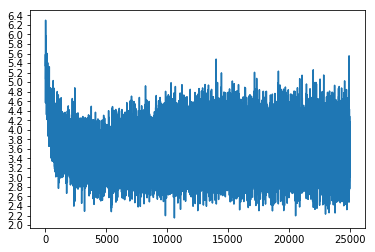

In [46]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2) # put ticks at regular intervals
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

show_plot(plot_losses)

# Evaluating the network

Evaluation is mostly the same as training, but there are no targets. Instead we always feed the decoder's predictions back to itself. Every time it predicts a word, we add it to the output string. If it predicts the EOS token we stop there. We also store the decoder's attention outputs for each step to display later.

In [20]:
def evaluate(sentence, max_length=MAX_LENGTH):
    input_variable = variable_from_sentence(input_lang, sentence)
    input_length = input_variable.size()[0]
    
    # Run through encoder
    encoder_hidden = encoder.init_hidden()
    encoder_outputs, encoder_hidden = encoder(input_variable, encoder_hidden)

    # Create starting vectors for decoder
    decoder_input = Variable(torch.LongTensor([[SOS_token]])) # SOS
    decoder_context = Variable(torch.zeros(1, decoder.hidden_size))
    if USE_CUDA:
        decoder_input = decoder_input.cuda()
        decoder_context = decoder_context.cuda()

    decoder_hidden = encoder_hidden
    
    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)
    
    # Run through decoder
    for di in range(max_length):
        decoder_output, decoder_context, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_context, decoder_hidden, encoder_outputs)
        decoder_attentions[di,:decoder_attention.size(2)] += decoder_attention.squeeze(0).squeeze(0).cpu().data

        # Choose top word from output
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        if ni == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(output_lang.index2word[ni.item()])
            
        # Next input is chosen word
        decoder_input = Variable(torch.LongTensor([[ni]]))
        if USE_CUDA: decoder_input = decoder_input.cuda()
    
    return decoded_words, decoder_attentions[:di+1, :len(encoder_outputs)]

We can evaluate random sentences from the training set and print out the input, target, and output to make some subjective quality judgements:

In [21]:
def evaluate_randomly():
    pair = random.choice(pairs)
    
    output_words, decoder_attn = evaluate(pair[0])
    output_sentence = ' '.join(output_words)
    
    
#     print('>', pair[0])
#     print('=', pair[1])
#     print('<', output_sentence)
#     print('')
    print '>', pair[0]
    print '=', pair[1]
    print '<', output_sentence
    print ''

In [55]:
evaluate_randomly()

> SOS 泛起 我们 的 童言无忌 EOS t ns v n NOP i NOE 4 NOR
= SOS 当 青春 挽起 发髻 EOS
< SOS 当 青春 是 记忆 EOS <EOS>



# Visualizing attention

A useful property of the attention mechanism is its highly interpretable outputs. Because it is used to weight specific encoder outputs of the input sequence, we can imagine looking where the network is focused most at each time step.

You could simply run `plt.matshow(attentions)` to see attention output displayed as a matrix, with the columns being input steps and rows being output steps:

In [ ]:
output_words, attentions = evaluate("je suis trop froid .")
plt.matshow(attentions.numpy())

For a better viewing experience we will do the extra work of adding axes and labels:

In [ ]:
def show_attention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

def evaluate_and_show_attention(input_sentence):
    output_words, attentions = evaluate(input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    show_attention(input_sentence, output_words, attentions)

In [ ]:
evaluate_and_show_attention("elle a cinq ans de moins que moi .")

In [ ]:
evaluate_and_show_attention("elle est trop petit .")

In [ ]:
evaluate_and_show_attention("je ne crains pas de mourir .")

In [ ]:
evaluate_and_show_attention("c est un jeune directeur plein de talent .")

# Exercises

* Try with a different dataset
    * Another language pair
    * Human &rarr; Machine (e.g. IOT commands)
    * Chat &rarr; Response
    * Question &rarr; Answer
* Replace the embedding pre-trained word embeddings such as word2vec or GloVe
* Try with more layers, more hidden units, and more sentences. Compare the training time and results.
* If you use a translation file where pairs have two of the same phrase (`I am test \t I am test`), you can use this as an autoencoder. Try this:
    * Train as an autoencoder
    * Save only the Encoder network
    * Train a new Decoder for translation from there